In [79]:
import os
import rawpy
import numpy as np
import math
import seaborn as sns
import cv2
import sys
import matplotlib.pyplot as plt
import pickle
import time
from IPython.display import clear_output

In [80]:
NUM_IMAGES = 200

## IMPORT IMAGES

In [81]:
def get_images():
    file = open('./dataset/Sony_train_list.txt').read()
    pairs = file.split('\n')
    np.random.shuffle(pairs)
    pairs = pairs[:NUM_IMAGES]
    
    image_paths = dict()
    image_paths['dark'] = []
    image_paths['bright'] = []
    
    images = dict()
    images['dark'] = []
    images['bright'] = []
    
    start_time = time.time()
    for idx, pair in enumerate(pairs):
        dark_path = pair.split()[0]
        dark_image = rawpy.imread('./dataset/'+dark_path).postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=8)
        dark_image = cv2.cvtColor(dark_image, cv2.COLOR_RGB2BGR)
        image_paths['dark'].append(dark_path)
        images['dark'].append(dark_image)
        
        bright_path = pair.split()[1]
        bright_image = rawpy.imread('./dataset/'+bright_path).postprocess(use_camera_wb=True, output_bps=8)
        bright_image = cv2.cvtColor(bright_image, cv2.COLOR_RGB2BGR)
        image_paths['bright'].append(bright_path)
        images['bright'].append(bright_image)
        
        print('Image Set: {}/{} \t {} \t {}'.format(idx+1, NUM_IMAGES, dark_path, bright_path))
    
    with open('./images.pickle', 'wb') as handle:
        pickle.dump(images, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    with open('./image_paths.pickle', 'wb') as handle:
        pickle.dump(image_paths, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    elapsed_time = time.time() - start_time
    print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))
    
    return image_paths, images

In [82]:
# Comment out the next line if you want to use pickle files
image_paths, images = get_images()

Image Set: 1/200 	 ./Sony/short/00189_01_0.033s.ARW 	 ./Sony/long/00189_00_10s.ARW
Image Set: 2/200 	 ./Sony/short/00114_06_0.1s.ARW 	 ./Sony/long/00114_00_30s.ARW
Image Set: 3/200 	 ./Sony/short/00043_07_0.1s.ARW 	 ./Sony/long/00043_00_10s.ARW
Image Set: 4/200 	 ./Sony/short/00066_01_0.1s.ARW 	 ./Sony/long/00066_00_10s.ARW
Image Set: 5/200 	 ./Sony/short/00127_01_0.1s.ARW 	 ./Sony/long/00127_00_30s.ARW
Image Set: 6/200 	 ./Sony/short/00066_02_0.1s.ARW 	 ./Sony/long/00066_00_10s.ARW
Image Set: 7/200 	 ./Sony/short/00057_05_0.1s.ARW 	 ./Sony/long/00057_00_10s.ARW
Image Set: 8/200 	 ./Sony/short/00118_05_0.1s.ARW 	 ./Sony/long/00118_00_30s.ARW
Image Set: 9/200 	 ./Sony/short/00060_00_0.04s.ARW 	 ./Sony/long/00060_00_10s.ARW
Image Set: 10/200 	 ./Sony/short/00202_04_0.04s.ARW 	 ./Sony/long/00202_00_10s.ARW
Image Set: 11/200 	 ./Sony/short/00063_06_0.1s.ARW 	 ./Sony/long/00063_00_10s.ARW
Image Set: 12/200 	 ./Sony/short/00018_01_0.1s.ARW 	 ./Sony/long/00018_00_10s.ARW
Image Set: 13/200 	 .

In [83]:
# with open('image_paths.pickle', 'rb') as handle:
#     image_paths = pickle.load(handle)

In [84]:
# with open('images.pickle', 'rb') as handle:
#     images = pickle.load(handle)

## GAMMA (METHOD 1 - Element Wise Log)

In [85]:
unweighted_image_gammas = []
weighted_d_image_gammas = []
weighted_b_image_gammas = []

start_time = time.time()
for idx, (bright, dark) in enumerate(zip(images['bright'], images['dark'])):
    print('Image Set {}'.format(idx+1), end='\t')
    
    bright_0 = np.where(bright.flatten()==0)[0]
    bright_255 = np.where(bright.flatten()==255)[0]
    dark_0 = np.where(dark.flatten()==0)[0]
    dark_255 = np.where(dark.flatten()==255)[0]
    bad_indices = list(set().union(bright_0, bright_255, dark_0, dark_255))
    
    filtered_bright = np.delete(bright, bad_indices)
    log_bright = np.log(filtered_bright)
    
    filtered_dark = np.delete(dark, bad_indices)
    log_dark = np.log(filtered_dark)
    
    log_array = np.divide(log_dark, log_bright, out=np.zeros_like(log_dark, dtype=np.float32), where=log_bright!=0)
    
    unweighted_gamma = np.average(log_array)
    unweighted_image_gammas.append(unweighted_gamma)
    
    weighted_d_gamma = np.average(log_array, weights=filtered_dark)
    weighted_d_image_gammas.append(weighted_d_gamma)
    
    weighted_b_gamma = np.average(log_array, weights=filtered_bright)
    weighted_b_image_gammas.append(weighted_b_gamma)
    
    print('Unweighted Gamma: {:.2f} \t Weighted Dark Gamma: {:.2f} \t Weighted Bright Gamma: {:.2f} \t'.\
          format(unweighted_gamma, weighted_d_gamma, weighted_b_gamma))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1	Unweighted Gamma: 0.18 	 Weighted Dark Gamma: 0.30 	 Weighted Bright Gamma: 0.15 	
Image Set 2	Unweighted Gamma: 0.01 	 Weighted Dark Gamma: 0.03 	 Weighted Bright Gamma: 0.01 	
Image Set 3	Unweighted Gamma: 0.17 	 Weighted Dark Gamma: 0.24 	 Weighted Bright Gamma: 0.20 	
Image Set 4	Unweighted Gamma: 0.01 	 Weighted Dark Gamma: 0.01 	 Weighted Bright Gamma: 0.01 	
Image Set 5	Unweighted Gamma: 0.10 	 Weighted Dark Gamma: 0.17 	 Weighted Bright Gamma: 0.10 	
Image Set 6	Unweighted Gamma: 0.01 	 Weighted Dark Gamma: 0.01 	 Weighted Bright Gamma: 0.01 	
Image Set 7	Unweighted Gamma: 0.01 	 Weighted Dark Gamma: 0.03 	 Weighted Bright Gamma: 0.01 	
Image Set 8	Unweighted Gamma: 0.04 	 Weighted Dark Gamma: 0.07 	 Weighted Bright Gamma: 0.05 	
Image Set 9	Unweighted Gamma: 0.04 	 Weighted Dark Gamma: 0.07 	 Weighted Bright Gamma: 0.05 	
Image Set 10	Unweighted Gamma: 0.08 	 Weighted Dark Gamma: 0.15 	 Weighted Bright Gamma: 0.11 	
Image Set 11	Unweighted Gamma: 0.08 	 Weighted Da

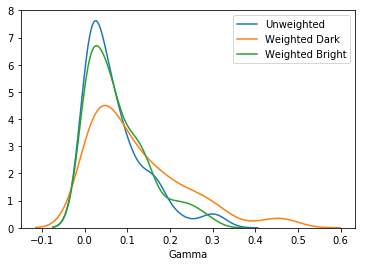

In [86]:
sns.distplot(unweighted_image_gammas, hist=False, label='Unweighted')
sns.distplot(weighted_d_image_gammas, hist=False, label='Weighted Dark')
sns.distplot(weighted_b_image_gammas, hist=False, label='Weighted Bright')
plt.xlabel('Gamma')
plt.legend()
plt.show()

In [87]:
print("Unweighted Gammas Mean: {:.2f}".format(np.mean(unweighted_image_gammas)))
print("Unweighted Gammas Std: {:.2f}".format(np.std(unweighted_image_gammas)))
print()

print("Weighted Dark Gammas Mean: {:.2f}".format(np.mean(weighted_d_image_gammas)))
print("Weighted Dark Gammas Std: {:.2f}".format(np.std(weighted_d_image_gammas)))
print()

print("Weighted Bright Gammas Mean: {:.2f}".format(np.mean(weighted_b_image_gammas)))
print("Weighted Bright Gammas Std: {:.2f}".format(np.std(weighted_b_image_gammas)))

Unweighted Gammas Mean: 0.07
Unweighted Gammas Std: 0.07

Weighted Dark Gammas Mean: 0.12
Weighted Dark Gammas Std: 0.11

Weighted Bright Gammas Mean: 0.08
Weighted Bright Gammas Std: 0.07


In [88]:
cv2.imwrite('./ex1.png', images['dark'][8])
cv2.imwrite('./ex2.png', images['bright'][8])
cv2.imwrite('./ex3.png', images['bright'][8]**0.2)

True

## GAMMAS (METHOD 2 - Optimization)

In [ ]:
candidate_gammas = np.linspace(0,1,1000)
image_gammas = []

start_time = time.time()
for img_idx, (bright, dark) in enumerate(zip(images['bright'], images['dark'])):
    print('Image Set {}'.format(img_idx+1), end='\t')
    
    optimal_gamma = -1
    min_diff = sys.maxsize
    
    bright_0 = np.where(bright.flatten()==0)[0]
    bright_255 = np.where(bright.flatten()==255)[0]
    dark_0 = np.where(dark.flatten()==0)[0]
    dark_255 = np.where(dark.flatten()==255)[0]
    bad_indices = list(set().union(bright_0, bright_255, dark_0, dark_255))
    
    filtered_bright = np.delete(bright, bad_indices)  
    filtered_dark = np.delete(dark, bad_indices)
    
    for g_idx, gamma in enumerate(candidate_gammas):
#         clear_output(wait=True)
        
        gamma_bright = filtered_bright**gamma
        if abs(np.average(gamma_bright) - np.average(filtered_dark)) < min_diff:
            optimal_gamma = gamma
            min_diff = abs(np.average(gamma_bright) - np.average(filtered_dark))
    
#         print("Gammas Tested: {}".format(g_idx+1))

    image_gammas.append(optimal_gamma)
    print('Avg Bright: {:.2f}   Avg Dark: {:.2f}   Min Diff: {:.2f}   Gamma: {:.2f}'.\
          format(np.average(filtered_bright), np.average(filtered_dark), min_diff, optimal_gamma))

elapsed_time = time.time() - start_time
print('Total Time Elapsed: {:.2f}s'.format(elapsed_time))

Image Set 1	Avg Bright: 75.71   Avg Dark: 2.27   Min Diff: 0.00   Gamma: 0.21
Image Set 2	Avg Bright: 123.50   Avg Dark: 1.08   Min Diff: 0.00   Gamma: 0.02
Image Set 3	Avg Bright: 147.35   Avg Dark: 2.92   Min Diff: 0.00   Gamma: 0.22
Image Set 4	Avg Bright: 169.33   Avg Dark: 1.05   Min Diff: 0.00   Gamma: 0.01
Image Set 5	Avg Bright: 69.99   Avg Dark: 1.70   Min Diff: 0.00   Gamma: 0.13
Image Set 6	Avg Bright: 169.35   Avg Dark: 1.05   Min Diff: 0.00   Gamma: 0.01
Image Set 7	Avg Bright: 155.88   Avg Dark: 1.07   Min Diff: 0.00   Gamma: 0.01
Image Set 8	Avg Bright: 145.56   Avg Dark: 1.33   Min Diff: 0.00   Gamma: 0.06
Image Set 9	Avg Bright: 151.53   Avg Dark: 1.34   Min Diff: 0.00   Gamma: 0.06
Image Set 10	Avg Bright: 130.04   Avg Dark: 1.77   Min Diff: 0.00   Gamma: 0.12
Image Set 11	Avg Bright: 135.56   Avg Dark: 1.77   Min Diff: 0.00   Gamma: 0.12
Image Set 12	Avg Bright: 138.59   Avg Dark: 1.90   Min Diff: 0.00   Gamma: 0.13
Image Set 13	Avg Bright: 84.03   Avg Dark: 1.09   M

In [90]:
np.mean(image_gammas)

0.11751751751751752